In [1]:
# Warnings may sometimes be printed, so let's prevent this.
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Analysin the dataset
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

# Connect to the SQLite database
conn = sqlite3.connect('data.db')

# Load the data
motion_df = pd.read_sql_query("SELECT * FROM motion", conn)
homes_df = pd.read_sql_query("SELECT * FROM homes", conn)

# Close the connection
conn.close()


In [3]:
# Convert datetime to datetime type
motion_df['datetime'] = pd.to_datetime(motion_df['datetime'])

print("Motion data shape:", motion_df.shape)
print(f"\nMotion data info: \n {motion_df.info()}")


print("\nHomes data shape:", homes_df.shape)
print(f"\nHomes data info: \n {homes_df.info()}")


Motion data shape: (580317, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 580317 entries, 0 to 580316
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype              
---  ------    --------------   -----              
 0   id        580317 non-null  object             
 1   home_id   580317 non-null  object             
 2   datetime  580317 non-null  datetime64[ns, UTC]
 3   location  580317 non-null  object             
dtypes: datetime64[ns, UTC](1), object(3)
memory usage: 17.7+ MB

Motion data info: 
 None

Homes data shape: (106, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  106 non-null    object
 1   multiple_occupancy  106 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 1.8+ KB

Homes data info: 
 None


In [4]:
print(f"Sample of motion data: \n {motion_df.head()}")
print('--'*30)
print(f"\nSample of homes data: \n {homes_df.head()}")

Sample of motion data: 
                                  id                           home_id  \
0  e41218b439d933a1cd9ad158f78e9198  205c42ec747e2db13cb92087a99433f1   
1  92d48d869ae50b0764cfb8d70494f618  7d2f2e0a9e059b4fb8106bb0ad4b8a39   
2  65c18ba64884442dd47c2fd4cf3630e4  44a880cc6fc3a7db3464092f650ae7f1   
3  90d6336d189c929aa50fa08e5aee5f41  49b83fce41b676266b98cd1e095f1c11   
4  6e3d73bed24b95ffdfe5ec017787f039  14328a0b7574e912c2e23d62c9476a07   

                   datetime location  
0 2024-01-01 00:00:10+00:00   lounge  
1 2024-01-01 00:00:17+00:00   lounge  
2 2024-01-01 00:00:18+00:00   lounge  
3 2024-01-01 00:00:43+00:00   lounge  
4 2024-01-01 00:00:57+00:00   lounge  
------------------------------------------------------------

Sample of homes data: 
                                  id  multiple_occupancy
0  dc922bd9bf8a2a9437642fe0dce9dcaa                   0
1  d40fc88629271da7b5833ed3f3222d17                   1
2  3fb064da180f02862063eca8e3b609c0             

In [5]:
# Check for missing values
print(f"Missing values in motion data: \n{motion_df.isnull().sum()} \n")
print(f"Missing values in homes data: \n{homes_df.isnull().sum()}")


Missing values in motion data: 
id          0
home_id     0
datetime    0
location    0
dtype: int64 

Missing values in homes data: 
id                    0
multiple_occupancy    0
dtype: int64


# Data distribution

There's a slight imbalance in occupancy types: 57.5% multiple occupancy vs 42.5% single occupancy. 


Occupancy distribution: multiple_occupancy
1    0.575472
0    0.424528
Name: proportion, dtype: float64


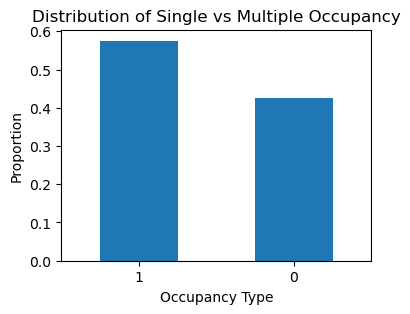

In [6]:
occupancy_distribution = homes_df['multiple_occupancy'].value_counts(normalize=True)
print(f"\nOccupancy distribution: {occupancy_distribution}")


plt.figure(figsize=(4, 3))
occupancy_distribution.plot(kind='bar')
plt.title('Distribution of Single vs Multiple Occupancy')
plt.xlabel('Occupancy Type')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.show()

# Motion Events by Location

Kitchen and lounge are the most active areas, followed by hallway and bedroom1.
Some locations like conservatory, study, and living room have very few events. 


Location distribution:
location
kitchen         0.272980
lounge          0.263787
hallway         0.167169
bedroom1        0.129986
bathroom1       0.085310
dining room     0.029386
WC1             0.018478
conservatory    0.013294
study           0.010072
living room     0.009538
Name: proportion, dtype: float64


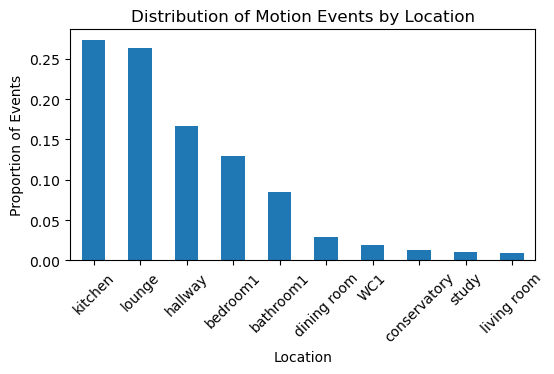

In [7]:
location_distribution = motion_df['location'].value_counts(normalize=True)
print("\nLocation distribution:")
print(location_distribution)

plt.figure(figsize=(6, 3))
location_distribution.plot(kind='bar')
plt.title('Distribution of Motion Events by Location')
plt.xlabel('Location')
plt.ylabel('Proportion of Events')
plt.xticks(rotation=45)
plt.show()

# Now, I want to see distribution of motion events by Location and Occupancy

In [8]:
motion_with_occupancy = motion_df.merge(homes_df[['id', 'multiple_occupancy']], left_on='home_id', right_on='id')

# Calculate the distribution for each occupancy type
single_occ_dist = motion_with_occupancy[motion_with_occupancy['multiple_occupancy'] == 0]['location'].value_counts(normalize=True)
multiple_occ_dist = motion_with_occupancy[motion_with_occupancy['multiple_occupancy'] == 1]['location'].value_counts(normalize=True)



In [9]:
# Combine the distributions into a single DataFrame
location_distribution = pd.DataFrame({
    'Single Occupancy': single_occ_dist,
    'Multiple Occupancy': multiple_occ_dist
}).fillna(0)

In [10]:
print("Location distribution")
location_distribution


Location distribution


,Single Occupancy,Multiple Occupancy
location,,
WC1,0.017727,0.018859
bathroom1,0.061159,0.097560
bedroom1,0.128627,0.130675
conservatory,0.000000,0.020038
dining room,0.053294,0.017259
hallway,0.086239,0.208219
kitchen,0.294771,0.261927
living room,0.018997,0.004740
lounge,0.339186,0.225542


### Different locations in single and multiple occupancy homes
I thought that the bathroom and hallway might be important factors for predicting home occupancy.

<Figure size 1500x600 with 0 Axes>

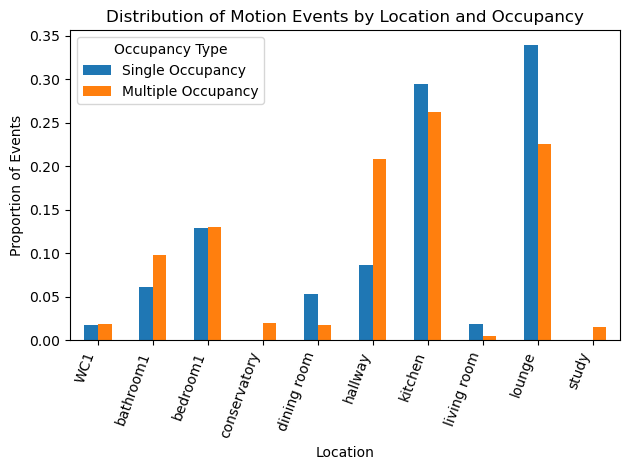

In [11]:
# Create a grouped bar plot
plt.figure(figsize=(15, 6))
location_distribution.plot(kind='bar')
plt.title('Distribution of Motion Events by Location and Occupancy')
plt.xlabel('Location')
plt.ylabel('Proportion of Events')
plt.xticks(rotation=70, ha='right')
plt.legend(title='Occupancy Type')
plt.tight_layout()
plt.show()

## Let's see the motion events by hour of day and day of week

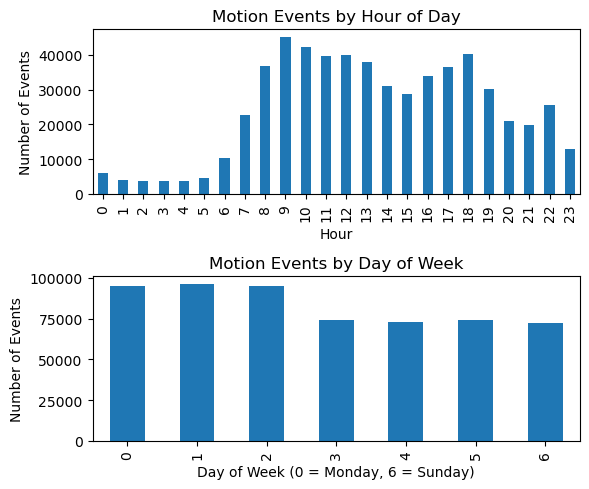

In [12]:
motion_df['hour'] = motion_df['datetime'].dt.hour
motion_df['day_of_week'] = motion_df['datetime'].dt.dayofweek

hourly_motion = motion_df.groupby('hour').size()
daily_motion = motion_df.groupby('day_of_week').size()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 5))

hourly_motion.plot(kind='bar', ax=ax1)
ax1.set_title('Motion Events by Hour of Day')
ax1.set_xlabel('Hour')
ax1.set_ylabel('Number of Events')

daily_motion.plot(kind='bar', ax=ax2)
ax2.set_title('Motion Events by Day of Week')
ax2.set_xlabel('Day of Week (0 = Monday, 6 = Sunday)')
ax2.set_ylabel('Number of Events')

plt.tight_layout()
plt.show()

In [13]:
motion_df[:5]

,id,home_id,datetime,location,hour,day_of_week
0,e41218b439d933a1cd9ad158f78e9198,205c42ec747e2db13cb92087a99433f1,2024-01-01 00:00:10+00:00,lounge,0,0
1,92d48d869ae50b0764cfb8d70494f618,7d2f2e0a9e059b4fb8106bb0ad4b8a39,2024-01-01 00:00:17+00:00,lounge,0,0
2,65c18ba64884442dd47c2fd4cf3630e4,44a880cc6fc3a7db3464092f650ae7f1,2024-01-01 00:00:18+00:00,lounge,0,0
3,90d6336d189c929aa50fa08e5aee5f41,49b83fce41b676266b98cd1e095f1c11,2024-01-01 00:00:43+00:00,lounge,0,0
4,6e3d73bed24b95ffdfe5ec017787f039,14328a0b7574e912c2e23d62c9476a07,2024-01-01 00:00:57+00:00,lounge,0,0


### Let's explore previous chart in more detail for both single and multiple home occupancy

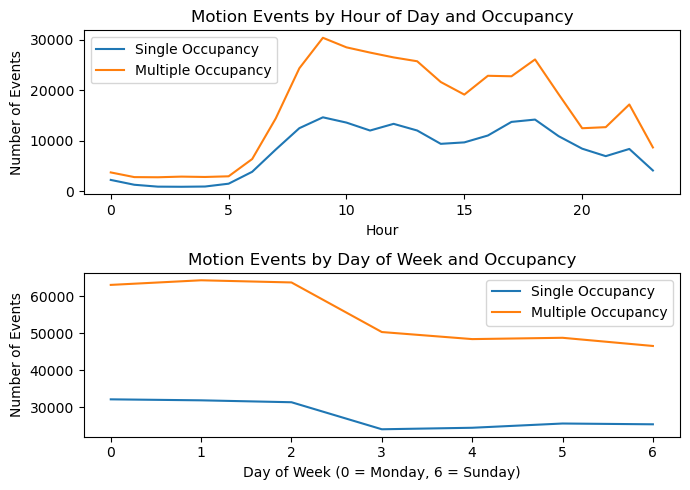

In [14]:
motion_with_occupancy = motion_df.merge(homes_df[['id', 'multiple_occupancy']], left_on='home_id', right_on='id')

hourly_motion_by_occupancy = motion_with_occupancy.groupby(['hour', 'multiple_occupancy']).size().unstack()
daily_motion_by_occupancy = motion_with_occupancy.groupby(['day_of_week', 'multiple_occupancy']).size().unstack()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 5))

hourly_motion_by_occupancy.plot(kind='line', ax=ax1)
ax1.set_title('Motion Events by Hour of Day and Occupancy')
ax1.set_xlabel('Hour')
ax1.set_ylabel('Number of Events')
ax1.legend(['Single Occupancy', 'Multiple Occupancy'])

daily_motion_by_occupancy.plot(kind='line', ax=ax2)
ax2.set_title('Motion Events by Day of Week and Occupancy')
ax2.set_xlabel('Day of Week (0 = Monday, 6 = Sunday)')
ax2.set_ylabel('Number of Events')
ax2.legend(['Single Occupancy', 'Multiple Occupancy'])

plt.tight_layout()
plt.show()

## Takeaways

I think we should definitely use the features of days for estimating home occupancy, as seen in the chart of Motion Events by Day of the Week and Occupancy

In [15]:
# Count visits for each room in each home
room_visits = motion_df.groupby(['home_id', 'location']).size().unstack(fill_value=0)
room_visits.head(3)

location,WC1,bathroom1,bedroom1,conservatory,dining room,hallway,kitchen,living room,lounge,study
home_id,,,,,,,,,,
0904961f621c9bd03542b43b992ec431,0,2,0,0,0,1315,2125,0,0,0
0f44ff9edd221e417195f4398d2f3853,0,609,1110,0,0,4156,4697,0,3299,1432
14328a0b7574e912c2e23d62c9476a07,415,1349,1544,0,373,3877,3001,0,3758,1660


In [16]:
# Calculate daily motion logs counts
motion_df['day_of_week'] = motion_df['datetime'].dt.dayofweek
daily_motion = motion_df.groupby(['home_id', 'day_of_week']).size().unstack(fill_value=0)
daily_motion.head(3)

day_of_week,0,1,2,3,4,5,6
home_id,,,,,,,
0904961f621c9bd03542b43b992ec431,553,465,600,570,405,473,376
0f44ff9edd221e417195f4398d2f3853,2556,2360,2692,2134,2132,1885,1544
14328a0b7574e912c2e23d62c9476a07,2614,3121,2888,2053,1878,1924,1499


In [17]:
# Calculate weekday and weekend averages
daily_motion['weekday_avg'] = daily_motion[[0, 1, 2, 3, 4]].mean(axis=1)
daily_motion['weekend_avg'] = daily_motion[[5, 6]].mean(axis=1)
daily_motion['weekend_weekday_ratio'] = daily_motion['weekend_avg'] / daily_motion['weekday_avg']
daily_motion.head()

day_of_week,0,1,2,3,4,5,6,weekday_avg,weekend_avg,weekend_weekday_ratio
home_id,,,,,,,,,,
0904961f621c9bd03542b43b992ec431,553,465,600,570,405,473,376,518.6,424.5,0.818550
0f44ff9edd221e417195f4398d2f3853,2556,2360,2692,2134,2132,1885,1544,2374.8,1714.5,0.721956
14328a0b7574e912c2e23d62c9476a07,2614,3121,2888,2053,1878,1924,1499,2510.8,1711.5,0.681655
15663392d490688cd4b0e5aa3d5b6ef3,1216,930,1054,832,736,776,752,953.6,764.0,0.801174
16d71b9c46d9abd765bf395818efe527,1053,1012,1076,966,891,959,823,999.6,891.0,0.891357


In [18]:
# Merge all features
result_df = room_visits.merge(daily_motion[['weekday_avg', 'weekend_avg', 'weekend_weekday_ratio']], 
                              left_index=True, right_index=True)
result_df = result_df.merge(homes_df[['id', 'multiple_occupancy']], left_index=True, right_on='id')
result_df.head(10)

,WC1,bathroom1,bedroom1,conservatory,dining room,hallway,kitchen,living room,lounge,study,weekday_avg,weekend_avg,weekend_weekday_ratio,id,multiple_occupancy
69,0,2,0,0,0,1315,2125,0,0,0,518.6,424.5,0.818550,0904961f621c9bd03542b43b992ec431,0
98,0,609,1110,0,0,4156,4697,0,3299,1432,2374.8,1714.5,0.721956,0f44ff9edd221e417195f4398d2f3853,1
73,415,1349,1544,0,373,3877,3001,0,3758,1660,2510.8,1711.5,0.681655,14328a0b7574e912c2e23d62c9476a07,1
66,0,592,1363,0,0,510,3346,0,485,0,953.6,764.0,0.801174,15663392d490688cd4b0e5aa3d5b6ef3,1
3,0,1546,359,0,0,191,0,0,4684,0,999.6,891.0,0.891357,16d71b9c46d9abd765bf395818efe527,0
32,480,782,1702,3051,0,1237,3466,0,5473,0,2296.4,2354.5,1.025300,205c42ec747e2db13cb92087a99433f1,1
14,0,0,1412,0,0,0,3753,0,2001,0,977.0,1140.5,1.167349,20a3ebd4470c712d6f6d99908d931e09,0
40,0,1875,4033,0,0,8220,6373,0,0,0,3016.2,2710.0,0.898482,2739e3f7409068a94cf6e3eac643c2e7,1
77,0,0,2151,0,0,1428,2958,0,840,0,1059.8,1039.0,0.980374,2a035e0f88dd05d3c5e61ebee0531a4c,0
63,7,797,1271,0,0,291,151,0,1993,0,659.6,606.0,0.918739,2b5ce37a65e82735416d69b987d99fe8,0


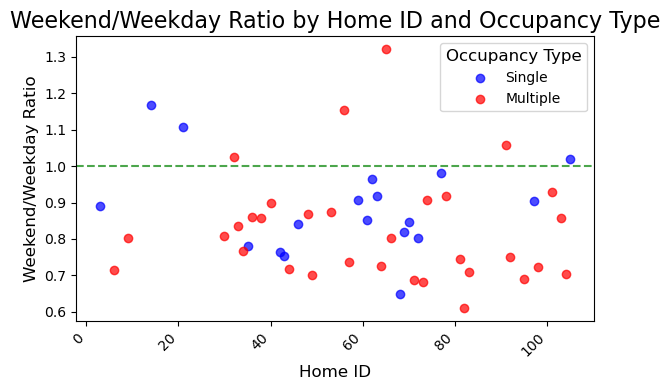

In [19]:

plt.figure(figsize=(6, 4))

# Explicitly define colors
colors = {0: 'blue', 1: 'red'}

# Create separate scatter plots for each occupancy type
for occupancy in [0, 1]:
    data = result_df[result_df['multiple_occupancy'] == occupancy]
    plt.scatter(data.index, data['weekend_weekday_ratio'], 
                c=colors[occupancy], 
                label='Single' if occupancy == 0 else 'Multiple',
                alpha=0.7)  # Add some transparency

plt.title('Weekend/Weekday Ratio by Home ID and Occupancy Type', fontsize=16)
plt.xlabel('Home ID', fontsize=12)
plt.ylabel('Weekend/Weekday Ratio', fontsize=12)
plt.legend(title='Occupancy Type', title_fontsize='12', fontsize='10')

# Add a horizontal line at y=1 for reference (where weekend = weekday activity)
plt.axhline(y=1, color='green', linestyle='--', alpha=0.7)

# Improve readability
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

#### There wasn't anything particularly important in the chart above, but I wanted to include this to increase the number of features since we have fewer.

#### Since the hallway and bathroom were important features in the chart above ("Distribution of Motion Events by Location and Occupancy"), I also wondered about their presence.

In [20]:
# Create binary features for presence of hallway and bathroom
result_df['has_hallway'] = (result_df['hallway'] > 0).astype(int)
result_df['has_bathroom'] = (result_df['bathroom1'] > 0).astype(int)
result_df.head()

,WC1,bathroom1,bedroom1,conservatory,dining room,hallway,kitchen,living room,lounge,study,weekday_avg,weekend_avg,weekend_weekday_ratio,id,multiple_occupancy,has_hallway,has_bathroom
69,0,2,0,0,0,1315,2125,0,0,0,518.6,424.5,0.818550,0904961f621c9bd03542b43b992ec431,0,1,1
98,0,609,1110,0,0,4156,4697,0,3299,1432,2374.8,1714.5,0.721956,0f44ff9edd221e417195f4398d2f3853,1,1,1
73,415,1349,1544,0,373,3877,3001,0,3758,1660,2510.8,1711.5,0.681655,14328a0b7574e912c2e23d62c9476a07,1,1,1
66,0,592,1363,0,0,510,3346,0,485,0,953.6,764.0,0.801174,15663392d490688cd4b0e5aa3d5b6ef3,1,1,1
3,0,1546,359,0,0,191,0,0,4684,0,999.6,891.0,0.891357,16d71b9c46d9abd765bf395818efe527,0,1,1


In [21]:
# Calculate the counts
hallway_counts = result_df.groupby('multiple_occupancy')['has_hallway'].value_counts().unstack(fill_value=0)
bathroom_counts = result_df.groupby('multiple_occupancy')['has_bathroom'].value_counts().unstack(fill_value=0)
# Print the actual counts
print(f"Hallway Counts: \n{hallway_counts} \n")
print(f"Bathroom Counts:\n{bathroom_counts}")

# Calculate percentages
hallway_percentages = hallway_counts.div(hallway_counts.sum(axis=1), axis=0) * 100
bathroom_percentages = bathroom_counts.div(bathroom_counts.sum(axis=1), axis=0) * 100
# Print the percentages
print(f"\n\nHallway Percentages: \n{hallway_percentages} \n")
print(f"Bathroom Percentages: \n{bathroom_percentages} \n")



Hallway Counts: 
has_hallway         0   1
multiple_occupancy       
0                   6  12
1                   3  29 

Bathroom Counts:
has_bathroom        0   1
multiple_occupancy       
0                   6  12
1                   1  31


Hallway Percentages: 
has_hallway                 0          1
multiple_occupancy                      
0                   33.333333  66.666667
1                    9.375000  90.625000 

Bathroom Percentages: 
has_bathroom                0          1
multiple_occupancy                      
0                   33.333333  66.666667
1                    3.125000  96.875000 



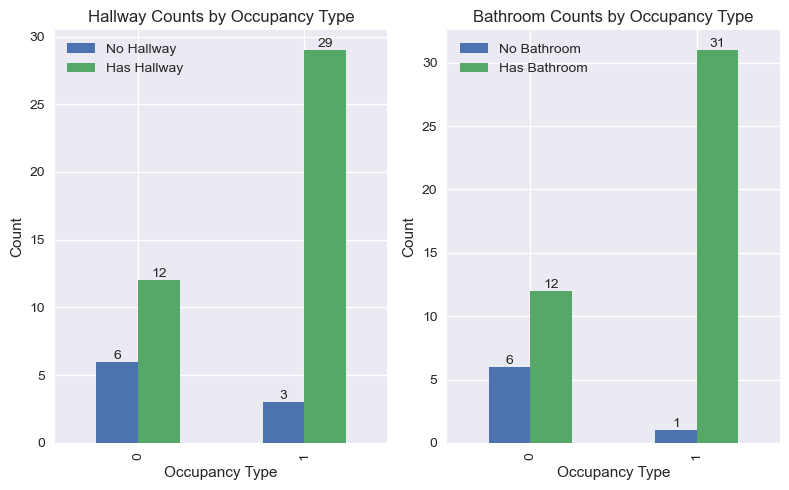

In [22]:
# Set up the plot style
plt.style.use('seaborn')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 5))

# Hallway Counts
hallway_counts.plot(kind='bar', ax=ax1)
ax1.set_title('Hallway Counts by Occupancy Type')
ax1.set_xlabel('Occupancy Type')
ax1.set_ylabel('Count')
ax1.legend(['No Hallway', 'Has Hallway'])
for container in ax1.containers:
    ax1.bar_label(container)

# Bathroom Counts
bathroom_counts.plot(kind='bar', ax=ax2)
ax2.set_title('Bathroom Counts by Occupancy Type')
ax2.set_xlabel('Occupancy Type')
ax2.set_ylabel('Count')
ax2.legend(['No Bathroom', 'Has Bathroom'])
for container in ax2.containers:
    ax2.bar_label(container)


plt.tight_layout()
plt.show()

### There are valuable insights into the relationship between hallways - bathrooms and occupancy types. We can use these features for training our model

## Let's see all of these day related features in charts.

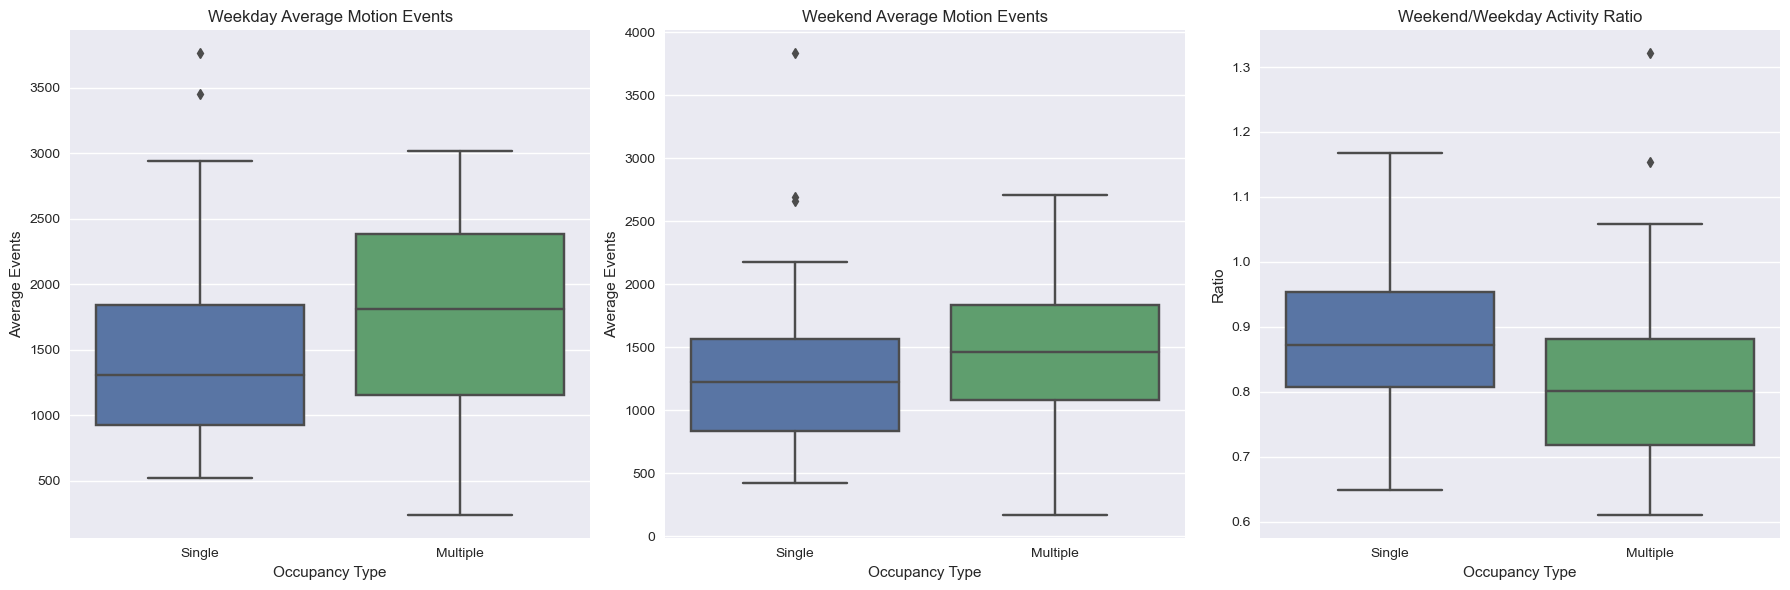

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# Weekday average
sns.boxplot(x='multiple_occupancy', y='weekday_avg', data=result_df, ax=ax1)
ax1.set_title('Weekday Average Motion Events')
ax1.set_xlabel('Occupancy Type')
ax1.set_ylabel('Average Events')
ax1.set_xticklabels(['Single', 'Multiple'])

# Weekend average
sns.boxplot(x='multiple_occupancy', y='weekend_avg', data=result_df, ax=ax2)
ax2.set_title('Weekend Average Motion Events')
ax2.set_xlabel('Occupancy Type')
ax2.set_ylabel('Average Events')
ax2.set_xticklabels(['Single', 'Multiple'])

# Weekend/Weekday ratio
sns.boxplot(x='multiple_occupancy', y='weekend_weekday_ratio', data=result_df, ax=ax3)
ax3.set_title('Weekend/Weekday Activity Ratio')
ax3.set_xlabel('Occupancy Type')
ax3.set_ylabel('Ratio')
ax3.set_xticklabels(['Single', 'Multiple'])

plt.tight_layout()
plt.show()

# Print summary statistics
# print(result_df.groupby('multiple_occupancy')[['weekday_avg', 'weekend_avg', 'weekend_weekday_ratio']].describe())

In [24]:
# Select features for the model
X = result_df.drop(['id','multiple_occupancy'], axis=1)
y = result_df['multiple_occupancy']


In [25]:
print(list(X.columns))

['WC1', 'bathroom1', 'bedroom1', 'conservatory', 'dining room', 'hallway', 'kitchen', 'living room', 'lounge', 'study', 'weekday_avg', 'weekend_avg', 'weekend_weekday_ratio', 'has_hallway', 'has_bathroom']


## We've done GridSearch as GridSearchCV helps find the best hyperparameters for our random forest model using cross validation, leading to better performance and more accurate predictions. Finally, we chose best model as best_rf_model.

In [26]:
# Import necessary libraries
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import pandas as pd


print("Hyperparameter tuning with GridSearchCV...")

# Define the parameter grid for Grid Search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Set up cross-validation
k = 10  # Number of folds
cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, 
                           param_grid=param_grid, 
                           cv=cv, 
                           n_jobs=-1,  # Use all available cores
                           verbose=2,  # Print progress
                           scoring='accuracy')

# Fit the model
grid_search.fit(X, y)

# Print the best parameters and best score
print("Best Parameters found by Grid Search:")
print(grid_search.best_params_)
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")

# Retrieve the best model
best_rf_model = grid_search.best_estimator_

# Use the best model to predict and evaluate further
y_pred = best_rf_model.predict(X)

# Calculate accuracy
accuracy = accuracy_score(y, y_pred)

# Generate classification report
report = classification_report(y, y_pred)

# Generate confusion matrix
cm = confusion_matrix(y, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(report)
print("Confusion Matrix:")
print(cm)

# This one was the best one in the previous run
# Best Parameters found by Grid Search:
# {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
# Best Cross-Validation Accuracy: 0.7200
# Accuracy: 0.9200
# Classification Report:
#               precision    recall  f1-score   support

#            0       1.00      0.78      0.88        18
#            1       0.89      1.00      0.94        32

#     accuracy                           0.92        50
#    macro avg       0.94      0.89      0.91        50
# weighted avg       0.93      0.92      0.92        50

# Confusion Matrix:
# [[14  4]
#  [ 0 32]]


Hyperparameter tuning with GridSearchCV...
Fitting 10 folds for each of 324 candidates, totalling 3240 fits


/Users/enesbasbug/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/enesbasbug/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/enesbasbug/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/enesbasbug/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/enesbasbug/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: Us

[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, 

[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, max

[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=10, max_feature

[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.1s
[CV] END max_dept

[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, m

[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_

Best Parameters found by Grid Search:
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best Cross-Validation Accuracy: 0.7200
Accuracy: 0.9200
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.78      0.88        18
           1       0.89      1.00      0.94        32

    accuracy                           0.92        50
   macro avg       0.94      0.89      0.91        50
weighted avg       0.93      0.92      0.92        50

Confusion Matrix:
[[14  4]
 [ 0 32]]


### Let's see the feature importances in a chart

Feature Importances:
                  Feature  Importance
5                 hallway    0.185107
1               bathroom1    0.156964
12  weekend_weekday_ratio    0.103384
10            weekday_avg    0.098894
2                bedroom1    0.092012
6                 kitchen    0.086945
8                  lounge    0.077685
11            weekend_avg    0.064690
13            has_hallway    0.060430
14           has_bathroom    0.056905
0                     WC1    0.016699
9                   study    0.000285
3            conservatory    0.000000
4             dining room    0.000000
7             living room    0.000000


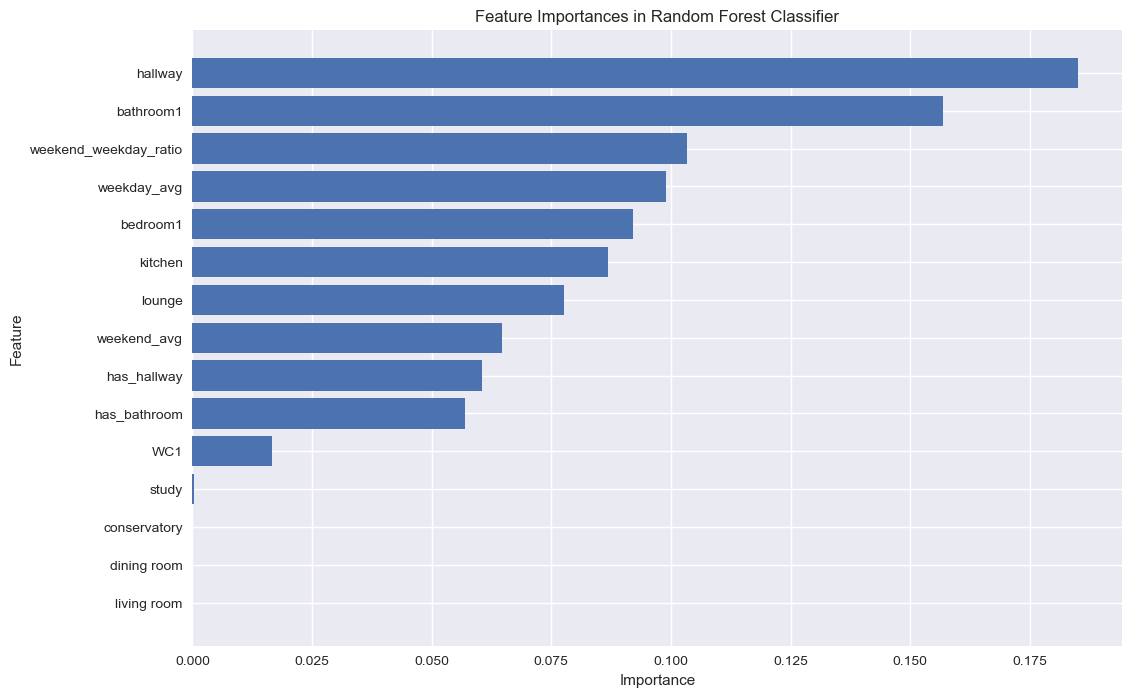

In [27]:

# Retrieve feature importances
feature_importances = best_rf_model.feature_importances_

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the feature importances
print("Feature Importances:")
print(feature_importance_df)

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances in Random Forest Classifier')
plt.gca().invert_yaxis()  # Reverse the order for better visualization
plt.show()


In [28]:
# 6. Using the Model for Prediction

def predict_occupancy(
    has_hallway, 
    has_bathroom, 
    hallway_visits, 
    bathroom_visits, 
    wc_visits,
    bedroom_visits,
    conservatory_visits,
    dining_room_visits,
    kitchen_visits,
    living_room_visits,
    lounge_visits,
    study_visits,
    weekday_avg, 
    weekend_avg, 
    weekend_weekday_ratio
):
    # Constructing a DataFrame with all features
    new_data = pd.DataFrame({
        'WC1': [wc_visits],
        'bathroom1': [bathroom_visits],
        'bedroom1': [bedroom_visits],
        'conservatory': [conservatory_visits],
        'dining room': [dining_room_visits],
        'hallway': [hallway_visits],
        'kitchen': [kitchen_visits],
        'living room': [living_room_visits],
        'lounge': [lounge_visits],
        'study': [study_visits],
        'weekday_avg': [weekday_avg],
        'weekend_avg': [weekend_avg],
        'weekend_weekday_ratio': [weekend_weekday_ratio],
        'has_hallway': [has_hallway],
        'has_bathroom': [has_bathroom]
    })
    
    # Make the prediction
    prediction = best_rf_model.predict(new_data)
    
    # Return the prediction result
    return "1 - Multiple Occupancy" if prediction[0] == 1 else "0 - Single Occupancy"

# Example usage
print("\nPrediction Example:")
print(predict_occupancy(
    has_hallway=1, 
    has_bathroom=1, 
    hallway_visits=1000, 
    bathroom_visits=1200, 
    wc_visits=300,
    bedroom_visits=500,
    conservatory_visits=100,
    dining_room_visits=400,
    kitchen_visits=600,
    living_room_visits=800,
    lounge_visits=200,
    study_visits=150,
    weekday_avg=1800, 
    weekend_avg=1500, 
    weekend_weekday_ratio=0.83
))



Prediction Example:
1 - Multiple Occupancy


In [29]:
from sklearn.tree import export_text

# Get the first single tree from the forest (out of 100)
tree = best_rf_model.estimators_[0]

# Get the text representation of the tree
tree_rules = export_text(tree, feature_names=list(X.columns), show_weights=False)

print("Tree Rules:")
print(tree_rules)


Tree Rules:
|--- has_hallway <= 0.50
|   |--- class: 0.0
|--- has_hallway >  0.50
|   |--- weekend_avg <= 1055.50
|   |   |--- hallway <= 1187.50
|   |   |   |--- class: 0.0
|   |   |--- hallway >  1187.50
|   |   |   |--- class: 0.0
|   |--- weekend_avg >  1055.50
|   |   |--- weekend_avg <= 1950.50
|   |   |   |--- class: 1.0
|   |   |--- weekend_avg >  1950.50
|   |   |   |--- class: 1.0



In [30]:
# !pip install onnxruntime skl2onnx

In [31]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
import onnxruntime as rt
import numpy as np

# Define the input feature dimensions
input_dim = X.shape[1]

# Convert the model to ONNX
initial_type = [('float_input', FloatTensorType([None, input_dim]))]
onx = convert_sklearn(best_rf_model, initial_types=initial_type)

# Save the model
with open("rf_model.onnx", "wb") as f:
    f.write(onx.SerializeToString())

print("Model exported to rf_model.onnx")


Model exported to rf_model.onnx
